In [1]:
# Pronóstico de Series de Tiempo

# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

<ipython-input-1-c9f892ff79c6>:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Pronóstico de Series de Tiempo

In [2]:
url = 'https://raw.githubusercontent.com/FrydaOviedo/Fisica_Computacional/main/Actividad1/Datos_diarios.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251'
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha','Precip','Evap','Tmax','Tmin',]
df_tkt = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python') 

# Hacemos una copia de trabajo y preservamos el dataframe original
df_tkt0 = df_tkt.copy()

# Cambiamos la palabra nulo por un vacío y verificamos
str_Nulo = 'Nulo'
df_tkt1 = df_tkt0.replace(to_replace=str_Nulo, value='', regex=True)

# Convertimos los valores de las variables ambientales a números flotantes y verificamos 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_tkt1[cols] = pd.to_numeric(df_tkt0[cols], errors='coerce')

# Definimos un nuevo dataframe por si hay que regresarse
df_tkt2 = df_tkt1.copy()
df_tkt2['Fecha'].head()

# Se convierte el objeto Fecha a variable fecha que python reconoce
df_tkt2['Fecha'] = pd.to_datetime(df_tkt2['Fecha'], dayfirst=True).copy()

# Añadimos dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.month para extraer el Año y Mes de la Fecha
df_tkt2['Año'] = df_tkt2['Fecha'].dt.year
df_tkt2['Mes'] = df_tkt2['Fecha'].dt.month

# Hacemos una copia del trabajo y es con el que trabajaremos para el análisis de datos
df_meteotkt = df_tkt2.copy()

# Eliminamos la columna de Mes(numérico) y agregamos Mes(caractéres)
df_meteotkt.drop('Mes', axis=1, inplace=True)
df_meteotkt['Mes'] = df_meteotkt['Fecha'].dt.strftime('%b')

# Nueva copia del DataFrame para Series de Tiempo
df_meteotkt_ts = df_meteotkt.copy()

# Reemplazamos el índice por la variable 'Fecha' 
df_meteotkt_ts = df_meteotkt.set_index('Fecha')
df_meteotkt_ts.info()

# Seleccionaremos un conjunto de años de 30 años
df_60 = df_meteotkt_ts[(df_meteotkt_ts['Año'] >= 1953) & (df_meteotkt_ts['Año'] < 1983)]
df_90 = df_meteotkt_ts[(df_meteotkt_ts['Año'] >= 1983) & (df_meteotkt_ts['Año'] < 2012)]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20904 entries, 1953-09-09 to 2012-11-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  20856 non-null  float64
 1   Evap    9815 non-null   float64
 2   Tmax    20790 non-null  float64
 3   Tmin    20801 non-null  float64
 4   Año     20904 non-null  int64  
 5   Mes     20904 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ MB


In [3]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar', size=18)
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de  Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [4]:
# haciendo una copia de la epoca de 1983 a 2012
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '2003-03', '2008-2'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()


,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2003-03-01,0.0,NaN,21.0,10.0,2003,Mar
2003-03-02,0.0,NaN,22.0,7.0,2003,Mar
2003-03-03,0.0,NaN,18.0,6.0,2003,Mar
2003-03-04,0.0,NaN,21.0,9.0,2003,Mar
2003-03-05,0.0,NaN,20.0,10.0,2003,Mar


Temperatura Máxima

In [5]:
# Vemos su encabezado
ts_90['Tmax'].head()

Fecha
2003-03-01    21.0
2003-03-02    22.0
2003-03-03    18.0
2003-03-04    21.0
2003-03-05    20.0
Name: Tmax, dtype: float64

In [6]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico
ts_test_TMX = ts_90['Tmax'].copy()

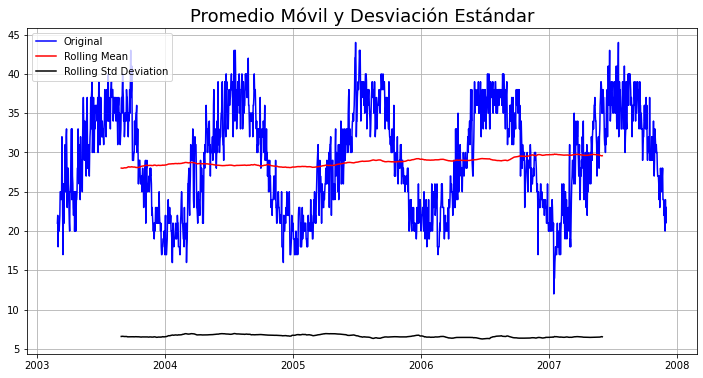

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.486238
p-value                           0.118859
#Lags Used                       12.000000
Number of Observations Used    1721.000000
Critical Value (1%)              -3.434155
Critical Value (5%)              -2.863221
Critical Value (10%)             -2.567665
dtype: float64


In [7]:
# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test_TMX)

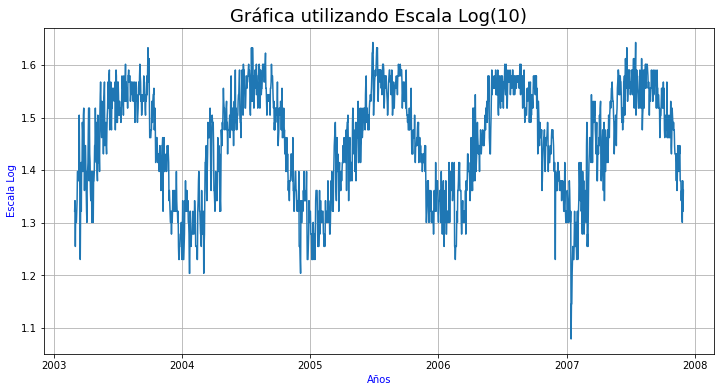

In [8]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_TMX_log = np.log10(ts_test_TMX)
plt.plot(ts_test_TMX_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)',size=18)
plt.grid()
plt.show();

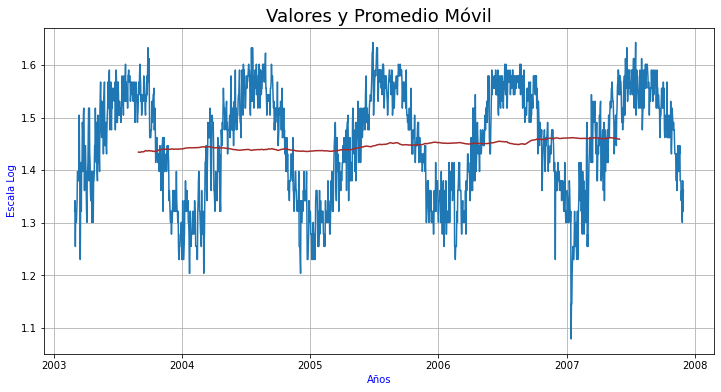

In [9]:
moving_avg_TMX = ts_test_TMX_log.rolling(365, center=True).mean()
plt.plot(ts_test_TMX_log)
plt.plot(moving_avg_TMX, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil', size=18)
plt.grid()
plt.show();

In [10]:
ts_test_log_moving_ave_diff_TMX = ts_test_TMX_log - moving_avg_TMX 
ts_test_log_moving_ave_diff_TMX.head()

Fecha
2003-03-01   NaN
2003-03-02   NaN
2003-03-03   NaN
2003-03-04   NaN
2003-03-05   NaN
Name: Tmax, dtype: float64

In [11]:
ts_test_log_moving_ave_diff_TMX.dropna(inplace=True)
ts_test_log_moving_ave_diff_TMX.head()

Fecha
2003-08-30    0.121448
2003-08-31    0.133348
2003-09-01    0.109593
2003-09-02    0.145308
2003-09-03    0.167704
Name: Tmax, dtype: float64

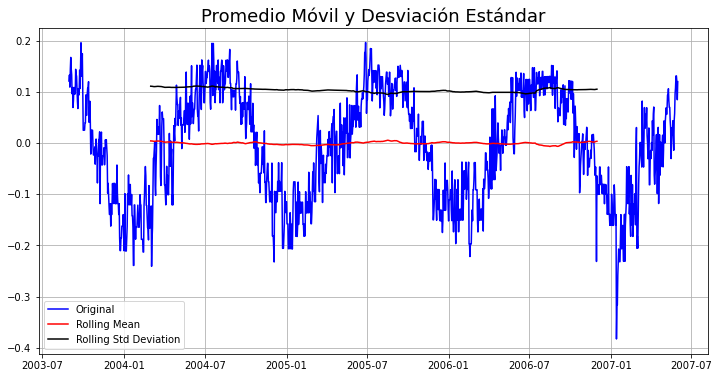

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.370336
p-value                           0.150285
#Lags Used                       12.000000
Number of Observations Used    1357.000000
Critical Value (1%)              -3.435178
Critical Value (5%)              -2.863672
Critical Value (10%)             -2.567905
dtype: float64


In [12]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff_TMX)

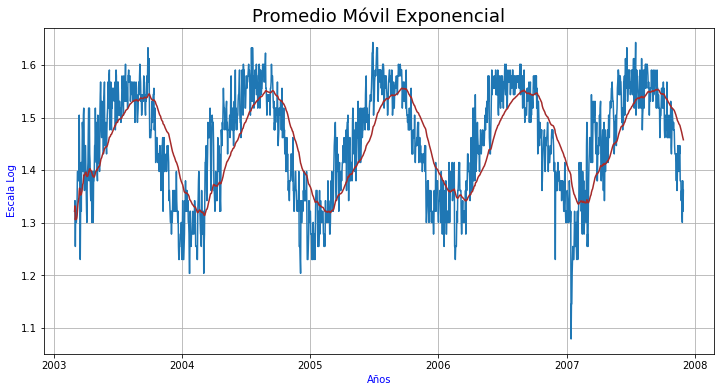

In [13]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg_TMX = ts_test_TMX_log.ewm(halflife=30).mean()
plt.plot(ts_test_TMX_log)
plt.plot(EWM_avg_TMX, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial', size=18)
plt.grid()
plt.show();

In [14]:
EWM_avg_TMX.head()


Fecha
2003-03-01    1.322219
2003-03-02    1.332438
2003-03-03    1.306119
2003-03-04    1.310285
2003-03-05    1.308347
Name: Tmax, dtype: float64

In [15]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff_TMX = ts_test_TMX_log - EWM_avg_TMX

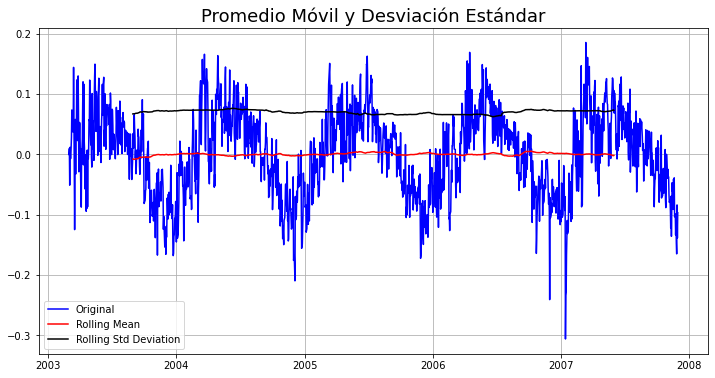

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.976360
p-value                           0.037162
#Lags Used                       16.000000
Number of Observations Used    1717.000000
Critical Value (1%)              -3.434164
Critical Value (5%)              -2.863225
Critical Value (10%)             -2.567667
dtype: float64


In [16]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff_TMX)

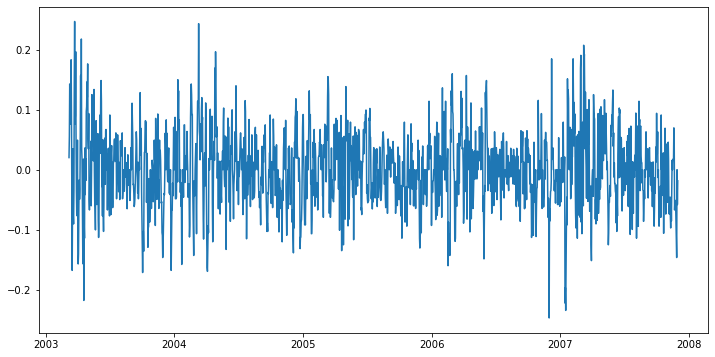

In [17]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff_TMX = ts_test_TMX_log - ts_test_TMX_log.shift(periods=7)
plt.plot(ts_test_log_diff_TMX);

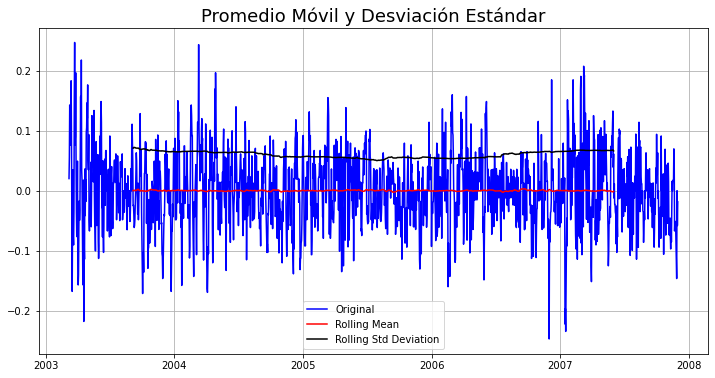

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.011309e+00
p-value                        2.197608e-12
#Lags Used                     2.300000e+01
Number of Observations Used    1.703000e+03
Critical Value (1%)           -3.434196e+00
Critical Value (5%)           -2.863239e+00
Critical Value (10%)          -2.567674e+00
dtype: float64


In [18]:
# Probamos la estacionaridad
ts_test_log_diff_TMX.dropna(inplace=True)
test_stationarity(ts_test_log_diff_TMX)

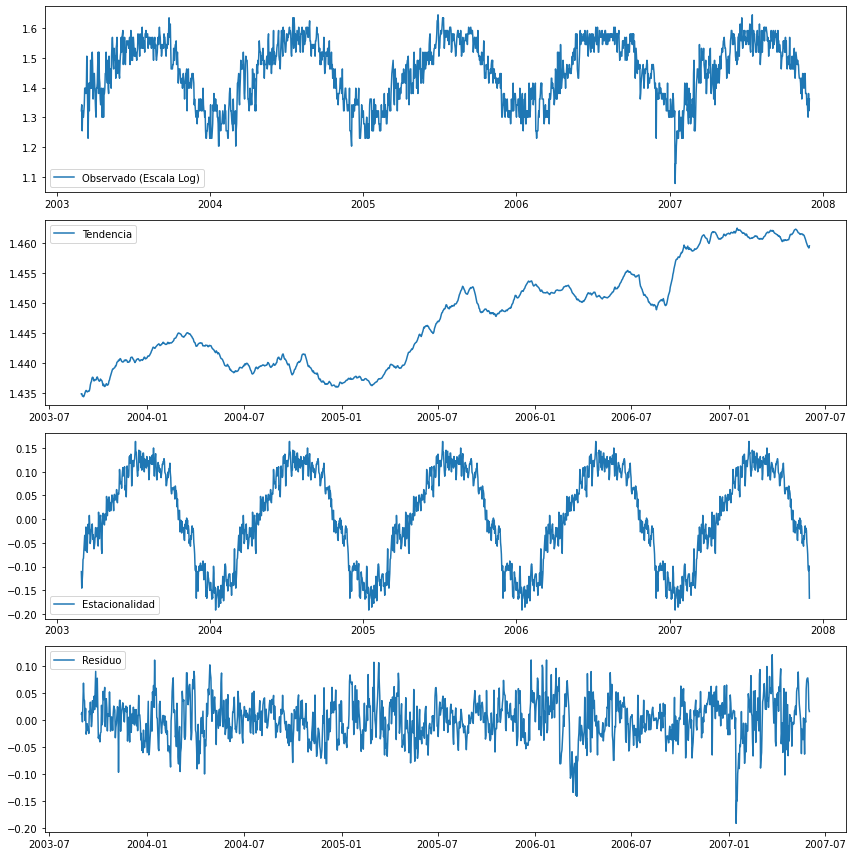

In [19]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition_TMX = sm.tsa.seasonal_decompose(ts_test_TMX_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend_TMX = decomposition_TMX.trend
seasonal_TMX = decomposition_TMX.seasonal
residue_TMX = decomposition_TMX.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_TMX_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_TMX, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_TMX, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue_TMX, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

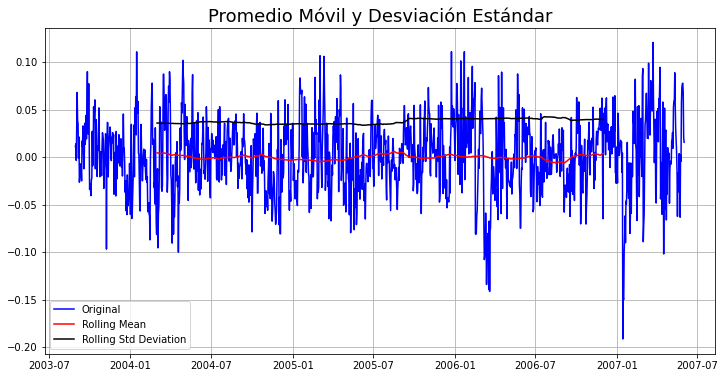

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.294671e+01
p-value                        3.443598e-24
#Lags Used                     2.000000e+00
Number of Observations Used    1.367000e+03
Critical Value (1%)           -3.435143e+00
Critical Value (5%)           -2.863657e+00
Critical Value (10%)          -2.567897e+00
dtype: float64


In [20]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose_TMX = residue_TMX 
ts_test_log_decompose_TMX.dropna(inplace=True)
test_stationarity(ts_test_log_decompose_TMX)

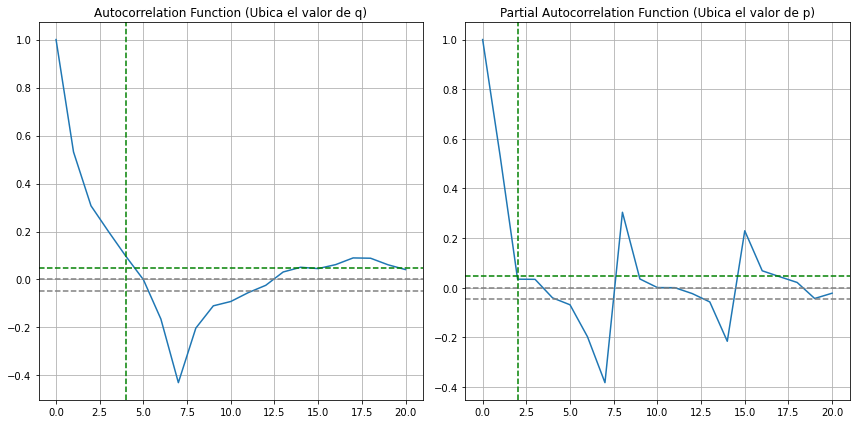

In [21]:
# Aplicamos ARIMA

lag_acf_TMX = acf(ts_test_log_diff_TMX, nlags=20)
lag_pacf_TMX = pacf(ts_test_log_diff_TMX, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf_TMX)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf_TMX)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1733
Model:                 ARIMA(2, 1, 0)   Log Likelihood                3166.455
Method:                       css-mle   S.D. of innovations              0.039
Date:                Wed, 24 Feb 2021   AIC                          -6324.911
Time:                        16:51:33   BIC                          -6303.080
Sample:                             1   HQIC                         -6316.837
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.237e-05      0.001      0.037      0.970      -0.001       0.001
ar.L1.D.Tmax    -0.3371      0.023    -14.392      0.000      -0.383      -0.291
ar.L2.D.Tmax    -0.2218      0.023     -9.45

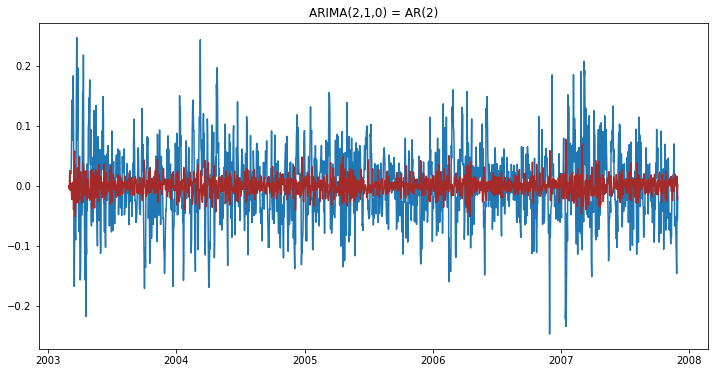

In [22]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model_TMX = ARIMA(ts_test_TMX_log, order=(2,1,0), missing='drop')
results_AR_TMX = model_TMX.fit(displ=-1)
plt.plot(ts_test_log_diff_TMX)
plt.plot(results_AR_TMX.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR_TMX.summary())

/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1733
Model:                 ARIMA(0, 1, 5)   Log Likelihood                3214.552
Method:                       css-mle   S.D. of innovations              0.038
Date:                Wed, 24 Feb 2021   AIC                          -6415.104
Time:                        16:51:59   BIC                          -6376.901
Sample:                             1   HQIC                         -6400.975
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.828e-05      0.000      0.068      0.946      -0.001       0.001
ma.L1.D.Tmax    -0.4145      0.024    -17.232      0.000      -0.462      -0.367
ma.L2.D.Tmax    -0.1794      0.026     -6.94

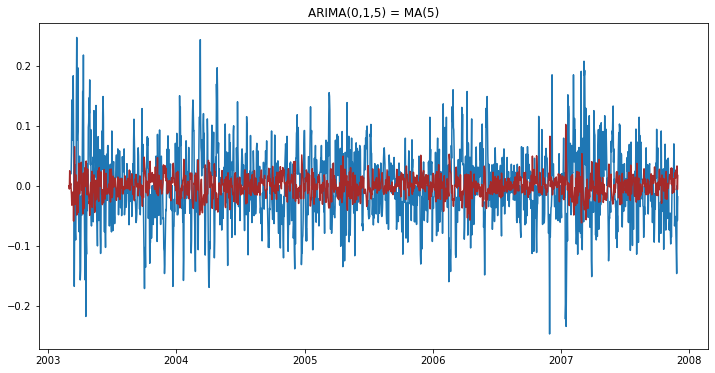

In [23]:
# Modelo MA(q): (p,d,q) = (0,1,5) 
model_TMX = ARIMA(ts_test_TMX_log, order=(0,1,5), missing='drop')
results_MA_TMX = model_TMX.fit(displ=-1)
plt.plot(ts_test_log_diff_TMX)
plt.plot(results_MA_TMX.fittedvalues, color='brown')
plt.title('ARIMA(0,1,5) = MA(5)')
print(results_MA_TMX.summary())

/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()

                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1733
Model:                 ARIMA(2, 1, 5)   Log Likelihood                3215.642
Method:                       css-mle   S.D. of innovations              0.038
Date:                Wed, 24 Feb 2021   AIC                          -6413.285
Time:                        16:52:30   BIC                          -6364.166
Sample:                             1   HQIC                         -6395.119
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.819e-05      0.000      0.070      0.944      -0.000       0.001
ar.L1.D.Tmax    -0.0609      0.840     -0.072      0.942      -1.706       1.585
ar.L2.D.Tmax     0.3225      0.499      0.64

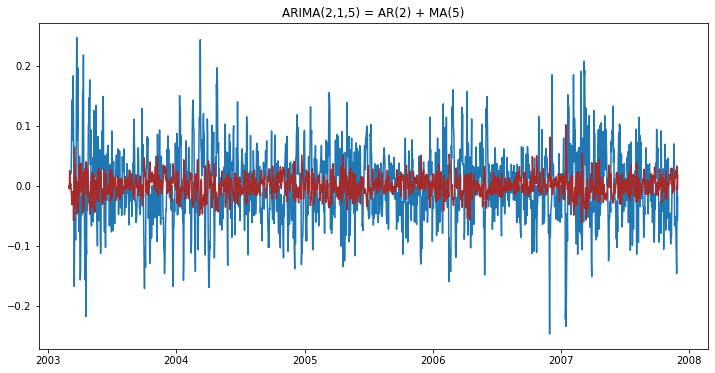

In [24]:
# Modelo ARIMA(p): (p,d,q) = (2,1,5) 
model_TMX = ARIMA(ts_test_TMX_log, order=(2,1,5), missing='drop')
results_ARIMA_TMX = model_TMX.fit(displ=-1)
plt.plot(ts_test_log_diff_TMX)
plt.plot(results_ARIMA_TMX.fittedvalues, color='brown')
plt.title('ARIMA(2,1,5) = AR(2) + MA(5)')
print(results_ARIMA_TMX.summary());

In [25]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff_TMX = pd.Series(results_ARIMA_TMX.fittedvalues, copy=True)
print(predictions_ARIMA_diff_TMX)

Fecha
2003-03-02    0.000018
2003-03-03   -0.005567
2003-03-04    0.025017
2003-03-05   -0.003852
2003-03-06    0.000642
                ...   
2007-11-26    0.015005
2007-11-27    0.026704
2007-11-28    0.032849
2007-11-29   -0.006729
2007-11-30    0.017370
Length: 1733, dtype: float64


In [26]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log_TMX = pd.Series(ts_test_TMX_log, index = ts_test_TMX_log.index)
predictions_ARIMA_log_TMX = predictions_ARIMA_log_TMX.add(predictions_ARIMA_diff_TMX)
print(predictions_ARIMA_log_TMX.head())
print(predictions_ARIMA_log_TMX.tail())

Fecha
2003-03-01         NaN
2003-03-02    1.342441
2003-03-03    1.249706
2003-03-04    1.347236
2003-03-05    1.297178
dtype: float64
Fecha
2007-11-26    1.337224
2007-11-27    1.327734
2007-11-28    1.413060
2007-11-29    1.315490
2007-11-30    1.379098
dtype: float64


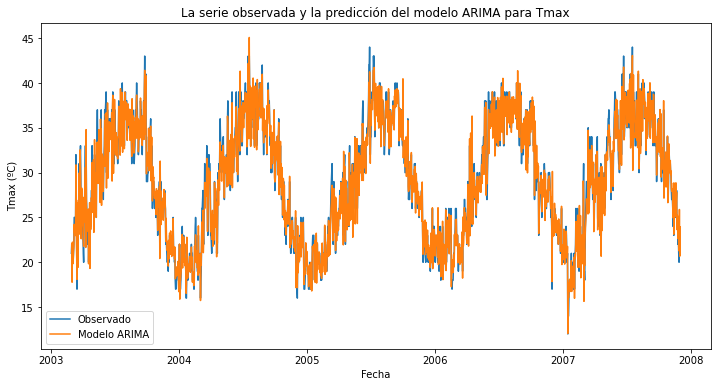

In [27]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA_TMX = 10**(predictions_ARIMA_log_TMX)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test_TMX, label='Observado');
plt.plot(predictions_ARIMA_TMX, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [28]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE_TMX = np.sqrt(np.mean((predictions_ARIMA_TMX - ts_test_TMX)**2))
print('RMSE:', RMSE_TMX)

RMSE: 1.0950608609437031


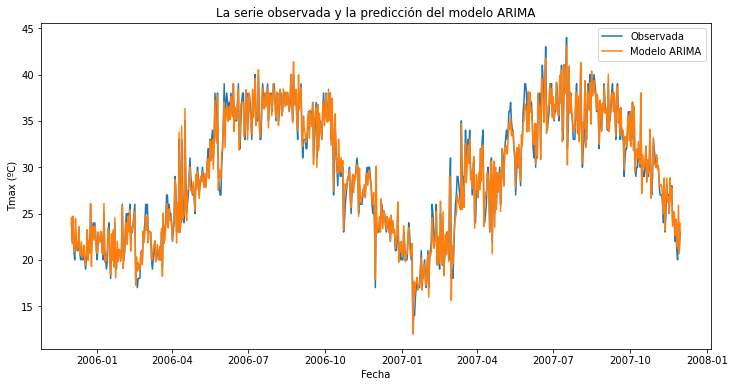

In [29]:
# Graficamos sólo los útimos datos de las series 
ts_test_last_TMX = ts_test_TMX.tail(730)
predictions_ARIMA_last_TMX = predictions_ARIMA_TMX.tail(730)
plt.plot(ts_test_last_TMX, label='Observada');
plt.plot(predictions_ARIMA_last_TMX, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

Temperatura Mínima

In [30]:
# Convertimos Tmin de ºC a ºK para poder usar escala logaritmica

C = 273.15
ts_90['TK'] = df_90['Tmin'] + C
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes,TK
Fecha,,,,,,,
2003-03-01,0.0,NaN,21.0,10.0,2003,Mar,283.15
2003-03-02,0.0,NaN,22.0,7.0,2003,Mar,280.15
2003-03-03,0.0,NaN,18.0,6.0,2003,Mar,279.15
2003-03-04,0.0,NaN,21.0,9.0,2003,Mar,282.15
2003-03-05,0.0,NaN,20.0,10.0,2003,Mar,283.15


In [31]:
# Vemos su encabezado
ts_90['TK'].head()

Fecha
2003-03-01    283.15
2003-03-02    280.15
2003-03-03    279.15
2003-03-04    282.15
2003-03-05    283.15
Name: TK, dtype: float64

In [32]:
# Definimos la Serie de Tiempo con Tmin que vamos a estudiar, le damos un nombre genérico
ts_test_TMN = ts_90['TK'].copy()

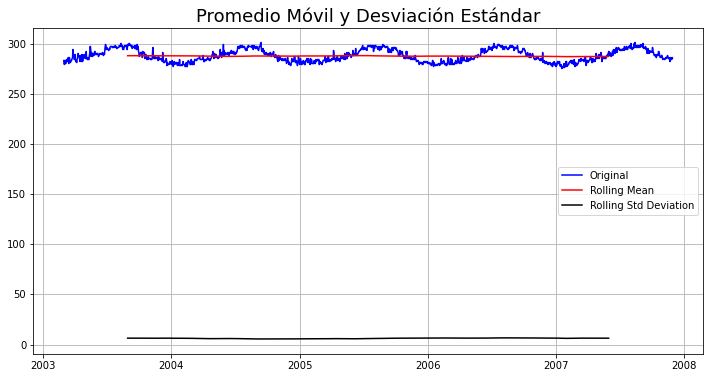

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.371499
p-value                           0.149943
#Lags Used                       10.000000
Number of Observations Used    1723.000000
Critical Value (1%)              -3.434151
Critical Value (5%)              -2.863219
Critical Value (10%)             -2.567664
dtype: float64


In [33]:
# Realizamos la Prueba de Estacionaridad de Tmin
test_stationarity(ts_test_TMN)

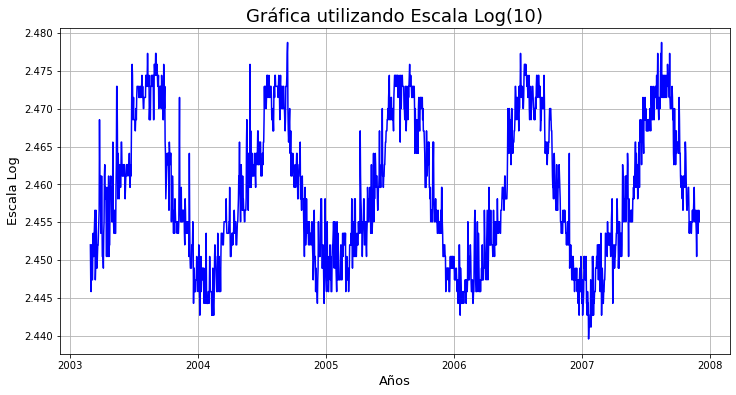

In [34]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_TMN_log = np.log10(ts_test_TMN)
plt.plot(ts_test_TMN_log, color='blue')
plt.xlabel('Años',size=13)
plt.ylabel('Escala Log',size=13)
plt.title('Gráfica utilizando Escala Log(10)',size=18)
plt.grid()
plt.show();

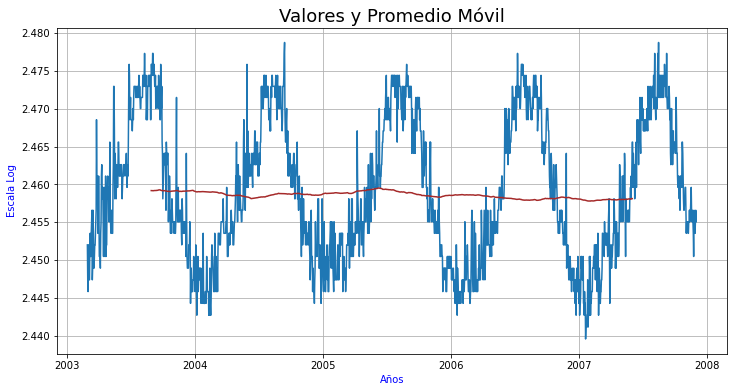

In [35]:
moving_avg_TMN = ts_test_TMN_log.rolling(365, center=True).mean()
plt.plot(ts_test_TMN_log)
plt.plot(moving_avg_TMN, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil', size=18)
plt.grid()
plt.show();

In [36]:
ts_test_log_moving_ave_diff_TMN = ts_test_TMN_log - moving_avg_TMN 
ts_test_log_moving_ave_diff_TMN.head()

Fecha
2003-03-01   NaN
2003-03-02   NaN
2003-03-03   NaN
2003-03-04   NaN
2003-03-05   NaN
Name: TK, dtype: float64

In [37]:
ts_test_log_moving_ave_diff_TMN.dropna(inplace=True)
ts_test_log_moving_ave_diff_TMN.head()

Fecha
2003-08-30    0.016696
2003-08-31    0.016700
2003-09-01    0.015250
2003-09-02    0.015246
2003-09-03    0.018154
Name: TK, dtype: float64

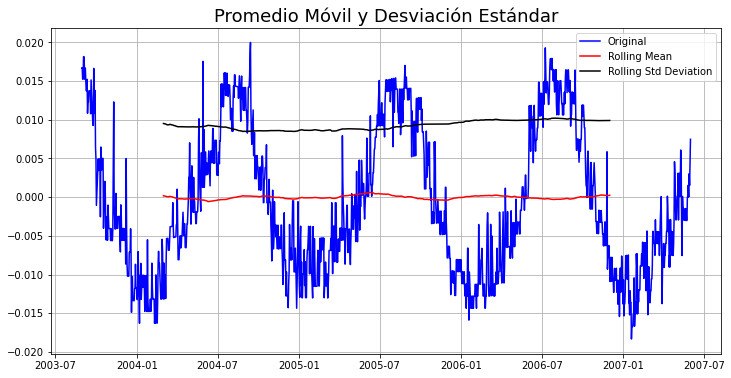

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.595178
p-value                           0.093998
#Lags Used                        8.000000
Number of Observations Used    1361.000000
Critical Value (1%)              -3.435164
Critical Value (5%)              -2.863666
Critical Value (10%)             -2.567902
dtype: float64


In [38]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff_TMN)

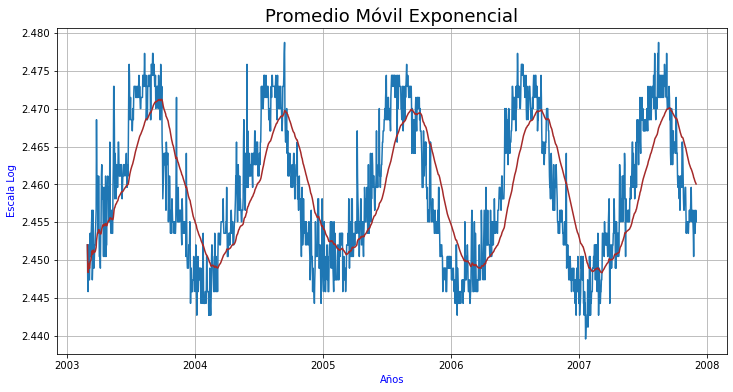

In [39]:

# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg_TMN = ts_test_TMN_log.ewm(halflife=30).mean()
plt.plot(ts_test_TMN_log)
plt.plot(EWM_avg_TMN, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial', size=18)
plt.grid()
plt.show();

In [40]:
EWM_avg_TMX.head()


Fecha
2003-03-01    1.322219
2003-03-02    1.332438
2003-03-03    1.306119
2003-03-04    1.310285
2003-03-05    1.308347
Name: Tmax, dtype: float64

In [42]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff_TMN = ts_test_TMN_log - EWM_avg_TMN

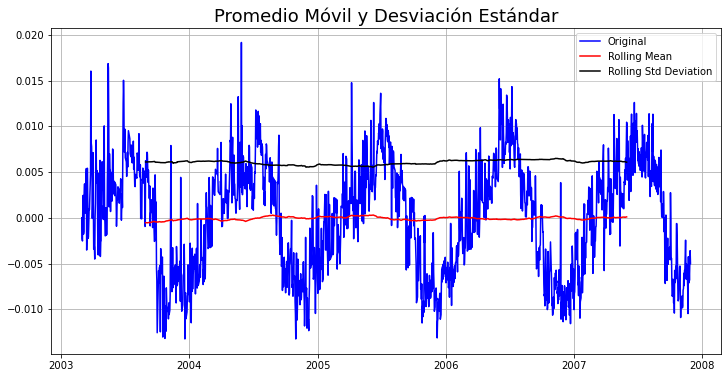

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.517787
p-value                           0.111206
#Lags Used                       15.000000
Number of Observations Used    1718.000000
Critical Value (1%)              -3.434162
Critical Value (5%)              -2.863224
Critical Value (10%)             -2.567666
dtype: float64


In [43]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff_TMN)

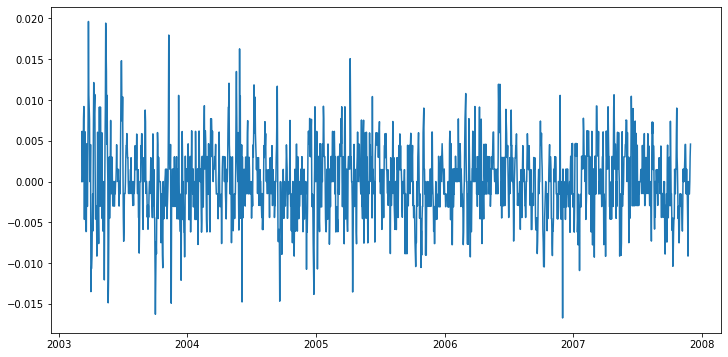

In [44]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff_TMN = ts_test_TMN_log - ts_test_TMN_log.shift(periods=7)
plt.plot(ts_test_log_diff_TMN);

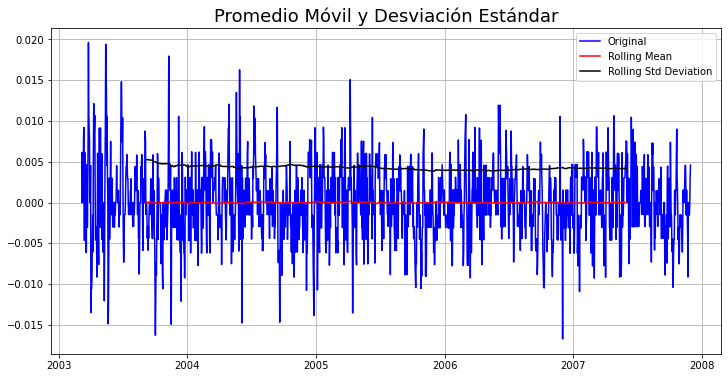

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -6.023455e+00
p-value                        1.474897e-07
#Lags Used                     2.500000e+01
Number of Observations Used    1.701000e+03
Critical Value (1%)           -3.434200e+00
Critical Value (5%)           -2.863241e+00
Critical Value (10%)          -2.567675e+00
dtype: float64


In [45]:
# Probamos la estacionaridad
ts_test_log_diff_TMN.dropna(inplace=True)
test_stationarity(ts_test_log_diff_TMN)

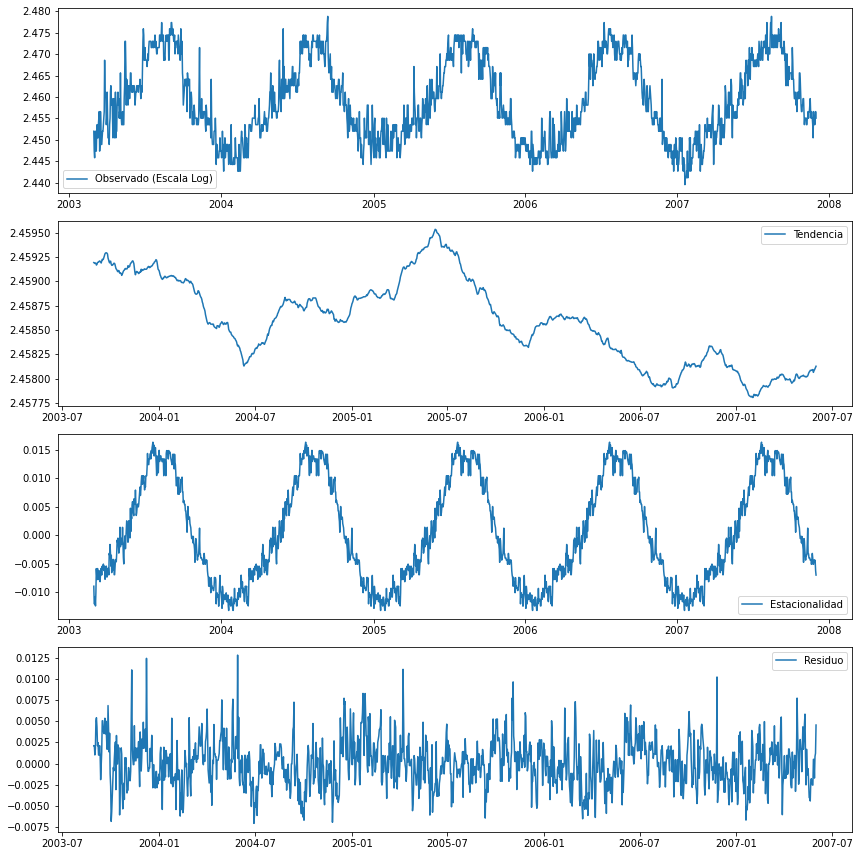

In [46]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition_TMN = sm.tsa.seasonal_decompose(ts_test_TMN_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend_TMN = decomposition_TMN.trend
seasonal_TMN = decomposition_TMN.seasonal
residue_TMN = decomposition_TMN.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_TMN_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_TMN, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_TMN, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue_TMN, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

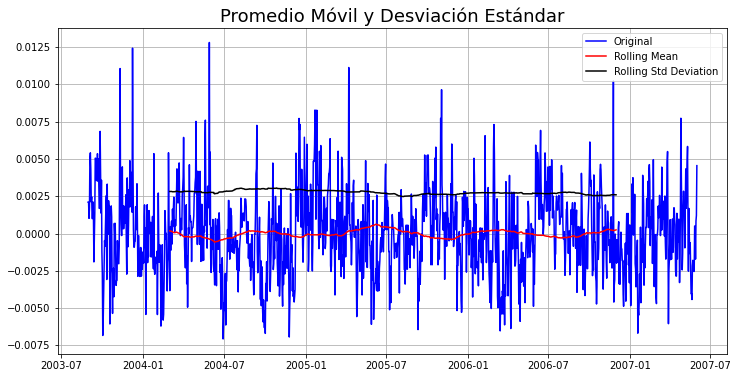

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.052597e+01
p-value                        9.415830e-19
#Lags Used                     4.000000e+00
Number of Observations Used    1.365000e+03
Critical Value (1%)           -3.435150e+00
Critical Value (5%)           -2.863660e+00
Critical Value (10%)          -2.567899e+00
dtype: float64


In [47]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose_TMN = residue_TMN 
ts_test_log_decompose_TMN.dropna(inplace=True)
test_stationarity(ts_test_log_decompose_TMN)

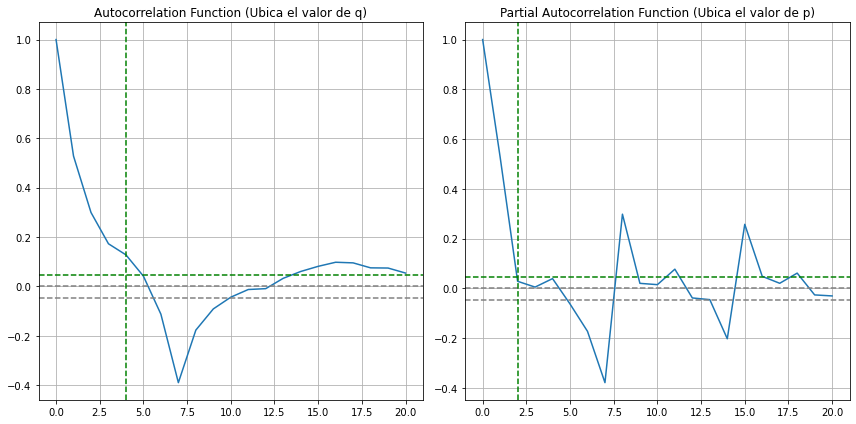

In [48]:
# Aplicamos ARIMA

lag_acf_TMN = acf(ts_test_log_diff_TMN, nlags=20)
lag_pacf_TMN = pacf(ts_test_log_diff_TMN, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf_TMN)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf_TMN)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                   D.TK   No. Observations:                 1733
Model:                 ARIMA(2, 1, 0)   Log Likelihood                7714.180
Method:                       css-mle   S.D. of innovations              0.003
Date:                Wed, 24 Feb 2021   AIC                         -15420.360
Time:                        17:15:26   BIC                         -15398.530
Sample:                             1   HQIC                        -15412.286
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.919e-06   4.58e-05      0.064      0.949   -8.68e-05    9.26e-05
ar.L1.D.TK    -0.3062      0.024    -12.937      0.000      -0.353      -0.260
ar.L2.D.TK    -0.1752      0.024     -7.405      0.0

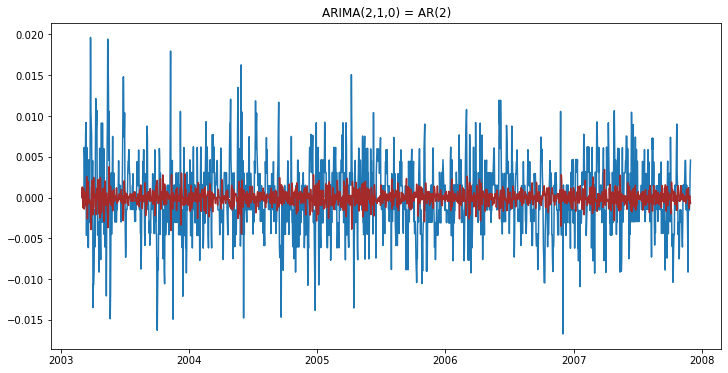

In [49]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model_TMN = ARIMA(ts_test_TMN_log, order=(2,1,0), missing='drop')
results_AR_TMN = model_TMN.fit(displ=-1)
plt.plot(ts_test_log_diff_TMN)
plt.plot(results_AR_TMN.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR_TMN.summary())

/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                   D.TK   No. Observations:                 1733
Model:                 ARIMA(0, 1, 5)   Log Likelihood                7777.927
Method:                       css-mle   S.D. of innovations              0.003
Date:                Wed, 24 Feb 2021   AIC                         -15541.854
Time:                        17:15:39   BIC                         -15503.651
Sample:                             1   HQIC                        -15527.725
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.77e-06    2.2e-05      0.126      0.900   -4.04e-05     4.6e-05
ma.L1.D.TK    -0.3896      0.024    -16.211      0.000      -0.437      -0.343
ma.L2.D.TK    -0.1569      0.026     -6.104      0.0

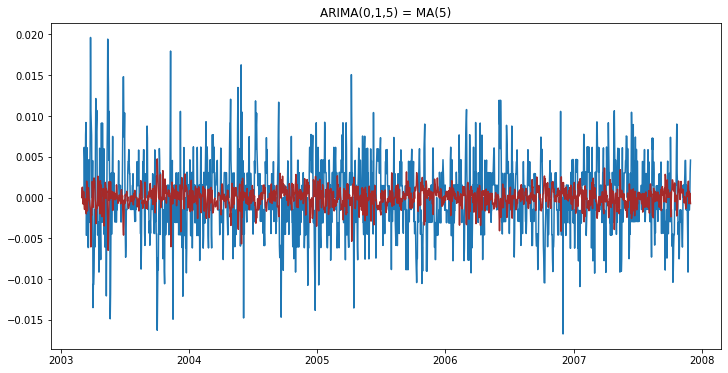

In [50]:
# Modelo MA(q): (p,d,q) = (0,1,5) 
model_TMN = ARIMA(ts_test_TMN_log, order=(0,1,5), missing='drop')
results_MA_TMN = model_TMN.fit(displ=-1)
plt.plot(ts_test_log_diff_TMN)
plt.plot(results_MA_TMN.fittedvalues, color='brown')
plt.title('ARIMA(0,1,5) = MA(5)')
print(results_MA_TMN.summary())

/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/frydaoviedo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                   D.TK   No. Observations:                 1733
Model:                 ARIMA(2, 1, 5)   Log Likelihood                7780.007
Method:                       css-mle   S.D. of innovations              0.003
Date:                Wed, 24 Feb 2021   AIC                         -15542.013
Time:                        17:16:03   BIC                         -15492.895
Sample:                             1   HQIC                        -15523.847
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.763e-06   2.23e-05      0.124      0.901   -4.09e-05    4.64e-05
ar.L1.D.TK    -0.1993      0.226     -0.880      0.379      -0.643       0.245
ar.L2.D.TK    -0.7477      0.214     -3.498      0.0

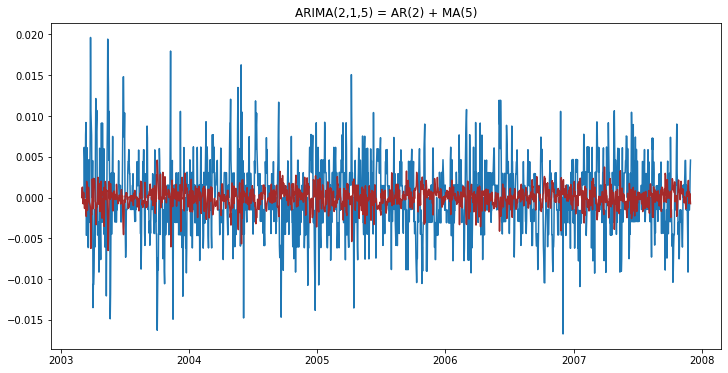

In [51]:
# Modelo ARIMA(p): (p,d,q) = (2,1,5) 
model_TMN = ARIMA(ts_test_TMN_log, order=(2,1,5), missing='drop')
results_ARIMA_TMN = model_TMN.fit(displ=-1)
plt.plot(ts_test_log_diff_TMN)
plt.plot(results_ARIMA_TMN.fittedvalues, color='brown')
plt.title('ARIMA(2,1,5) = AR(2) + MA(5)')
print(results_ARIMA_TMN.summary());

In [52]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff_TMN = pd.Series(results_ARIMA_TMN.fittedvalues, copy=True)
print(predictions_ARIMA_diff_TMN)

Fecha
2003-03-02    0.000003
2003-03-03    0.001194
2003-03-04    0.001276
2003-03-05   -0.000260
2003-03-06   -0.000760
                ...   
2007-11-26    0.000694
2007-11-27   -0.000484
2007-11-28    0.000497
2007-11-29   -0.000152
2007-11-30   -0.000746
Length: 1733, dtype: float64


In [53]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log_TMN = pd.Series(ts_test_TMN_log, index = ts_test_TMN_log.index)
predictions_ARIMA_log_TMN = predictions_ARIMA_log_TMN.add(predictions_ARIMA_diff_TMN)
print(predictions_ARIMA_log_TMN.head())
print(predictions_ARIMA_log_TMN.tail())

Fecha
2003-03-01         NaN
2003-03-02    2.447393
2003-03-03    2.447032
2003-03-04    2.451756
2003-03-05    2.451757
dtype: float64
Fecha
2007-11-26    2.455767
2007-11-27    2.453064
2007-11-28    2.455570
2007-11-29    2.456442
2007-11-30    2.454328
dtype: float64


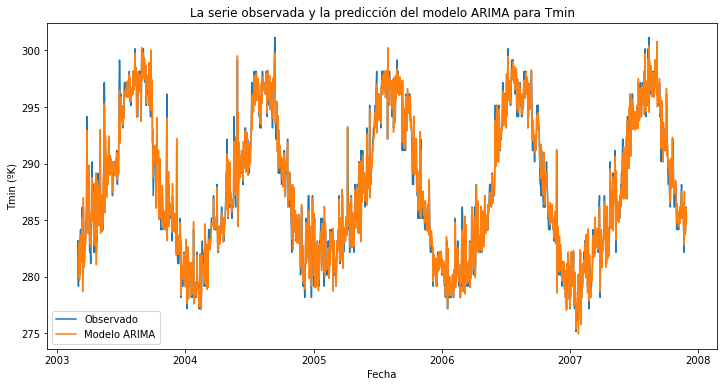

In [54]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA_TMN = 10**(predictions_ARIMA_log_TMN)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test_TMN, label='Observado');
plt.plot(predictions_ARIMA_TMN, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºK)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmin')
plt.legend(loc='best');

In [55]:
print(predictions_ARIMA_TMN)

Fecha
2003-03-01           NaN
2003-03-02    280.151782
2003-03-03    279.918639
2003-03-04    282.980371
2003-03-05    282.980644
                 ...    
2007-11-26    285.605877
2007-11-27    283.833622
2007-11-28    285.476543
2007-11-29    286.049850
2007-11-30    284.660776
Length: 1734, dtype: float64


In [56]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE_TMN = np.sqrt(np.mean((predictions_ARIMA_TMN - ts_test_TMN)**2))
print('RMSE:', RMSE_TMN)

RMSE: 0.798451629255278


In [57]:
# Convertimos temperaturas de ºK a ºC

C = 273.15

predictions_ARIMA_TMN_C = predictions_ARIMA_TMN - C
print(predictions_ARIMA_TMN_C.head())

ts_test_TMN_C = ts_test_TMN - C
print(ts_test_TMN_C.head())


Fecha
2003-03-01         NaN
2003-03-02    7.001782
2003-03-03    6.768639
2003-03-04    9.830371
2003-03-05    9.830644
dtype: float64
Fecha
2003-03-01    10.0
2003-03-02     7.0
2003-03-03     6.0
2003-03-04     9.0
2003-03-05    10.0
Name: TK, dtype: float64


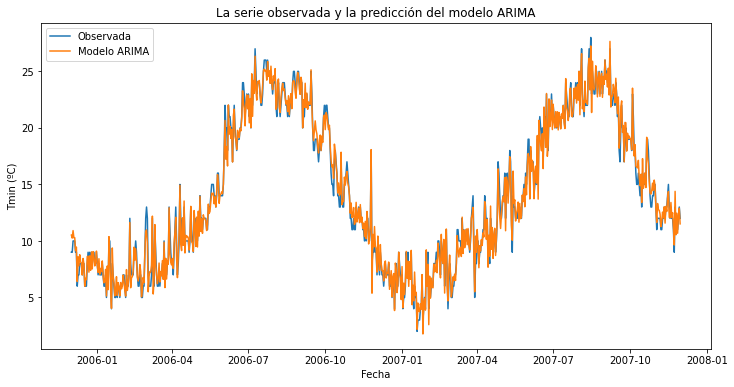

In [58]:
# Graficamos sólo los útimos datos de las series 
ts_test_last_TMN_C = ts_test_TMN_C.tail(730)
predictions_ARIMA_last_TMN = predictions_ARIMA_TMN_C.tail(730)
plt.plot(ts_test_last_TMN_C, label='Observada');
plt.plot(predictions_ARIMA_last_TMN, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');